In [1]:
# importing all necessary libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS


from tqdm import tqdm_notebook

import warnings

In [44]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

pd.options.display.float_format = '{:.4f}'.format

warnings.filterwarnings('ignore')

plt.style.use('dark_background')

In [3]:
# reading in the provided data set

initial_df = pd.read_csv(r'C:\Users\79175\Desktop\BGI Group Recruiting/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv',
                delimiter = '\t')

# Restructuring the initial dataset in order for it to be used for clustering
The initial data set has to be restructured in such a way that:
   1. 'cell' is used as a unique index; 
   2. 'geneID' is used as a feature; 
   3. 'MIDCounts' is used to place the respective values inside each gene based feature.

In [4]:
# Creating a list containing all columns that will be in the final dataset
columns_for_restrucred_df = ['x', 'y']


for i in initial_df['geneID'].unique():
    columns_for_restrucred_df.append(i)

In [5]:
# Creating the restructured data set

restructured_df = pd.DataFrame(index = initial_df['cell'].unique(), columns = columns_for_restrucred_df)

In [6]:
# Fill in the values for x and y variables

for i in tqdm_notebook(restructured_df.index):
    restructured_df['x'].loc[i] = initial_df[initial_df['cell'] == i]['x'].mean()
    restructured_df['y'].loc[i] = initial_df[initial_df['cell'] == i]['y'].mean()

In [7]:
# Fill in the values for features based on cell genetic composition

for i in tqdm_notebook(restructured_df.index):
    d = initial_df[initial_df['cell'] == i][['geneID', 'MIDCounts']].T.to_dict()
    for j in d.keys():
        restructured_df[d[j]['geneID']].loc[i] = d[j]['MIDCounts']

# Data Cleaning

1. Currently there are a lot of gene based features that are missing more than 90% of entries. These features will not be useful for clustering and, therefore, are dropped at this step. <br><br>
2. During data analysis, it was discovered that there are some entries that "pollute" the data. In order to get rid of them, a model is created that identifies this "polluting cluster". The cluster is then removed from the data set.

## Step 1: Deleting features that are missing more than 90% of entries

In [8]:
# Calculate the percentage of missing entries for each feature

empty_feat_list = restructured_df.isnull().sum().sort_values(ascending = True)/len(restructured_df)*100

In [9]:
# Creating a list containing features that are missing less than 90% of entries

list_of_features_to_use = empty_feat_list.reset_index()[empty_feat_list.reset_index()[0] < 90]['index'].tolist()

In [10]:
# Removing features that are missing more than 90% of the entries from the restructured data set

restructured_df = restructured_df[list_of_features_to_use]

There are still NaN entries present in the data set. NaN means that this particular gene is not present in this particular cell. Therefore, an "educated guess" was taken to replace NaN values with 0s.

In [11]:
# Filling missing entries with 0s

restructured_df = restructured_df.fillna(0)

## Step 2: Creating a model in order to identify the "polluting" cluster and remove it from the data set

In [12]:
# Creating an instance of Standard Scaler

standard_scaler = StandardScaler()

In [13]:
# Scaling the data

scaled_data_for_pca_cleaning = standard_scaler.fit_transform(restructured_df)

In [14]:
# Creating an instance of PCA Model

pca_model_for_cleaning = PCA(n_components = 100)

In [15]:
# Fitting PCA model and getting the new features that it provides in order to use them for modelling in the future.

pca_data_for_cleaning = pca_model_for_cleaning.fit_transform(scaled_data_for_pca_cleaning)

Data preparation is finished

### Sub-Model Creation
After carrying out an extensive analysis it was found that 3 KMeans models with the number of clusters set to 5,7,11 when combined with 3 Hierarchical models (5,7,11 clusters) give good clusterization results.

#### KMeans Models

In [16]:
k_means_model_11 = KMeans(n_clusters=11, random_state = 41)

In [17]:
k_means_model_11_results = k_means_model_11.fit_predict(pca_data_for_cleaning)

In [18]:
k_means_model_5 = KMeans(n_clusters=5, random_state = 42)   

In [19]:
k_means_model_5_results = k_means_model_5.fit_predict(pca_data_for_cleaning)

In [20]:
k_means_model_7 = KMeans(n_clusters=7, random_state = 42) 

In [21]:
k_means_model_7_results = k_means_model_7.fit_predict(pca_data_for_cleaning)

#### 6 models that will be used in an ensemle are created. Now their results are combined into a single data set which later be used to run another clusterisation algorithm upon it.

In [22]:
# data that will be used to create a data frame containing the results of KMeans and Hirarchical models

data = {'KMEANS':k_means_model_11_results.tolist(), 'K7':k_means_model_7_results, 'K5':k_means_model_5_results}

In [23]:
# creating a data set that will contain the results of KMeans and Hierarchical algorithms 

ensemble_data = pd.DataFrame(data = data)

#### Creating an ensemble model
In this section a final model is created wich takes in the results of 3 KMeans models (5,7,11 clusters) and 3 Hierarchical models (5,7,11 clusters) as features. <br> <br>

In [24]:
# scaling the data

ensemble_data = standard_scaler.fit_transform(ensemble_data)

In [25]:
# The objective of the model is to distinguish 9 clusters found in the original publication

ensemble_model = KMeans(n_clusters=11, random_state = 42)

In [26]:
# Insering the label into restructured data set in order to drop the label that is "polluting" the result

restructured_df['label'] = ensemble_model.fit_predict(ensemble_data)

In [27]:
# Removing the "polluting" cluster from the data set

restructured_df = restructured_df[restructured_df['label'] != restructured_df.loc[175898]['label']]

### Data Cleaning Part is Finished

# Modeling section
The structure of the final model can be described in several points:
   1. A final data set consists of 12 features in total. 2 are "x" and "y" coordinates of the cell. 10 are Principle Components that are created by running a Principle Component Analysis on 517 gene based features from the restructured data set. 
<br><br>
Reducing the number of gene based features allowed the model to "extract" more information from the spatial features (x and y coordinates).<br> <br>
   2. "spatial_influence" parameter controls the influence of the spatial features "x" and "y" on the output of the model. 
<br><br>
The parameter can be adjusted and the results of the model will change accordingly. If the parameter is set to 1, then only spatial features will be considered by the model. If the parameter is set to 0, then only gene based Principal Components are considered. 
<br>
Changing the parameter will result in wrong coloring and labeling.

<br><br>
This section is split into several parts:
1. Creating 10 principle components that are based on the cell genetic configuration (517 gene based features)
2. Merging "spatial" and "gene based" data sets and scaling the result of the join
3. "spatial_influence" parameter is defined
4. The model is created
5. The final visualization is created

## Part 1: Principle component analysis
This step is aimed at creating 10 principle components out of 517 gene based features

In [96]:
# Creating a data set that contains only gene based features

gene_data_set = restructured_df.drop(['x', 'y'], axis = 1)

In [97]:
# Scaling the data for principle component analysis

gene_data_set_scaled = standard_scaler.fit_transform(gene_data_set)

In [98]:
# Creating a PCA model which would output 10 gene based principle components

pca_gene_model = PCA(n_components=10)

In [99]:
# Getting the resulting 10 principle components

pca_data = pca_gene_model.fit_transform(gene_data_set_scaled)

In [100]:
# Creating a data set that consists of gene based 10 principle components

genes_PC_dataframe = pd.DataFrame(pca_data, columns = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8','PC_9','PC_10'])

## Part 2: Merging spatial and gene based data sets and scaling the result of the join

In [101]:
# Merging spatial and gene based data sets

genes_PC_dataframe['x'] = restructured_df.reset_index()['x']
genes_PC_dataframe['y'] = restructured_df.reset_index()['y']

In [102]:
# Scaling the result of the join

genes_PC_dataframe_scaled = standard_scaler.fit_transform(genes_PC_dataframe)

In [103]:
# Adding feature names to the scaled data in order to introduce "spatial_influence" parameter

final_data_frame = pd.DataFrame(genes_PC_dataframe_scaled, columns = genes_PC_dataframe.columns)

## Part 3: "spatial_influence" parameter defined
This parameter can control the influence of spatial coordinates on the clusterization. 
1. If the parameter is set to 1, then only spatial features are considered by the clusterization model. 
2. If the parameter is set to 0, then only gene based principle components are considered by the model.

#### The recommended value for the parameter is 0.3. <br> 
Please, note, that changing the value of the parameter will results in wrong coloring and labeling of the clusters.

In [104]:
# value of "spatial_influence" parameter is defined by the user
 
spatial_influence = float(input('Please input spatial influence parameter from 0 to 1: '))

# Spatial and gene based features are scaled accordingly

for col in final_data_frame.columns:
    if col[:2] == 'PC':
        final_data_frame[col] = final_data_frame[col]*(1-spatial_influence)
    else:
        final_data_frame[col] = final_data_frame[col]*spatial_influence

Please input spatial influence parameter from 0 to 1: 0.3


## Part 4: Model Creation
KMeans model with 11 clusters gives optimal results. <br>

random_state parameter is included to match colors and labels with the correct clusters in the visualization section

In [105]:
k_means_pricniple_model = KMeans(n_clusters=11, random_state=44)

In [106]:
k_means_pricniple_model.fit(final_data_frame)

KMeans(n_clusters=11, random_state=44)

## Part 5: Visualization of the results

In [107]:
# Defining necessary objects in order to create the visualization

final_data_frame['label']=k_means_pricniple_model.labels_

BGI_palette = sns.color_palette(['#A5005D', '#FFFB00', '#FF463B', '#53F7A3', '#560010', '#028334', '#92C6E4', '#0165A2', '#FDE9E9', '#FC32FF', '#00BBF6'])

In [108]:
# counting the labels in order to correctly place the names of the genes and the colors for the visualization

value_counts_df = final_data_frame['label'].value_counts().reset_index()

In [109]:
# Gene Names are placed in a separate column in order to use them as labels for the visualization
final_data_frame['Gene_Name'] = 1
for i in range(len(final_data_frame)):
    if final_data_frame['label'].loc[i] == value_counts_df['index'][0]:
        final_data_frame['Gene_Name'].loc[i] = 'Glu Neu'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][1]:
        final_data_frame['Gene_Name'].loc[i] = 'Glu NeuB'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][2]:
        final_data_frame['Gene_Name'].loc[i] = 'GABA Neu'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][3]:
        final_data_frame['Gene_Name'].loc[i] = 'NeuB'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][4]:
        final_data_frame['Gene_Name'].loc[i] = 'Micro (?)'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][5]:
        final_data_frame['Gene_Name'].loc[i] = 'Unidentified_1'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][6]:
        final_data_frame['Gene_Name'].loc[i] = 'Unidentified_2'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][7]:
        final_data_frame['Gene_Name'].loc[i] = 'Fibro'
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][8]:
        final_data_frame['Gene_Name'].loc[i] = 'RGC (?)'        
    elif final_data_frame['label'].loc[i] == value_counts_df['index'][9]:
        final_data_frame['Gene_Name'].loc[i] = 'Ery'
    else:
        final_data_frame['Gene_Name'].loc[i] = 'Unidentified_3'

In [110]:
# color_dictionary_based_on_counts = {
#     value_counts_df['index'][0]:'#A2C7F4', value_counts_df['index'][1]:'#0742CF', value_counts_df['index'][2]:'#FBE0E6',
#     value_counts_df['index'][3]:'#D100FB', value_counts_df['index'][4]:'#FBA8A8', value_counts_df['index'][5]:'#C0FBEF',
#     value_counts_df['index'][6]:'#5BFAA4', value_counts_df['index'][7]:'#FE473A', value_counts_df['index'][8]:'#2B9DFA',
#     value_counts_df['index'][9]:'#FBF600', value_counts_df['index'][10]:'#FBEEC2'} 

color_dictionary_based_on_names = {
    'Glu Neu':'#A2C7F4', 'Glu NeuB':'#0742CF', 'GABA Neu':'#FBE0E6',
    'NeuB':'#D100FB', 'Micro (?)':'#FBA8A8', 'Unidentified_1':'#C0FBEF',
    'Unidentified_2':'#5BFAA4', 'Fibro':'#FE473A', 'RGC (?)':'#2B9DFA',
    'Ery':'#FBF600', 'Unidentified_3':'#FBEEC2'} 

Due to Python's internal randomness this is as close as I could come with placing names and colors accurately. The clusters should be well distinguishable in any case, however, their names might be missplaced. If this happens, please, comment out plt.legend in line 11 and uncomment plt.legend in line 12 in the cell below.

''

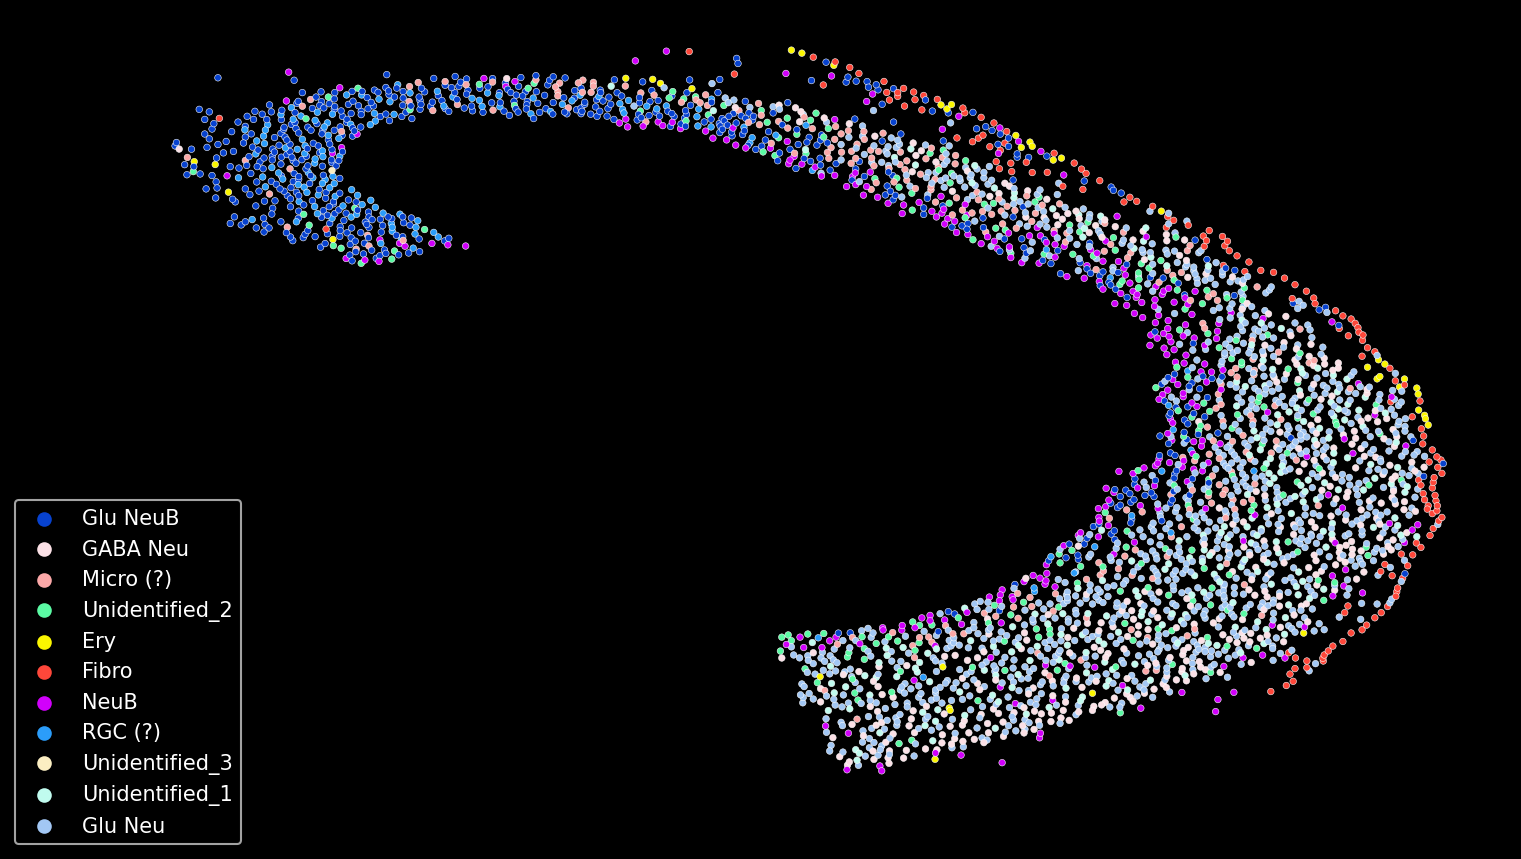

In [111]:
# Visualization creation

plt.figure(figsize = (12,7), dpi = 150)

sns.scatterplot(final_data_frame['x'], final_data_frame['y'], hue = final_data_frame['Gene_Name'], s = 10, palette = color_dictionary_based_on_names)



plt.axis('off')

plt.legend(bbox_to_anchor = [0.1, 0.4])
#plt.legend([], [])
;